<a href="https://colab.research.google.com/github/CT-Cultures/Content/blob/master/RegOverview_Issue.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# [1] Setting up Environment and Install Requirements

## 1.1 Set Working Directory, Install Requirements

In [ ]:
import os
import sys
# Set Path
from google.colab import drive
drive.mount('/content/drive')
path_wd = '/content/drive/MyDrive/Github/Content'
os.chdir(path_wd)

!pip install -r sources/ChinaFilm/requirements.txt
!apt-get update # to update ubuntu to correctly run apt install
!apt install chromium-chromedriver
!cp /usr/lib/chromium-browser/chromedriver /usr/bin
!pip install selenium
sys.path.insert(0,'/usr/lib/chromium-browser/chromedriver')

## 1.2 Load and Initialize the Movie Registration Class

In [ ]:
!#Load Libraries
import gc
import pandas as pd
from selenium import webdriver
from bs4 import BeautifulSoup
import re
from sources.ChinaFilm.Record_Registration import Registration # assume relative path at path_wd

chrome_options = webdriver.ChromeOptions()
chrome_options.add_argument('--headless')
chrome_options.add_argument('--no-sandbox')
chrome_options.add_argument('--disable-dev-shm-usage')

# Initialize Registration Class
driver = webdriver.Chrome('chromedriver',chrome_options=chrome_options)
dy_reg = Registration(driver)

## 1.3 Load Latest Registration Publication

In [ ]:
os.chdir('/content/drive/MyDrive/Github/Content/sources/ChinaFilm')
##########################################
# Use update_first=True to get latest records from China Film's Website
df = dy_reg.Refined_Records(update_first =True)
##########################################
curr_issue_name = df.sort_values(['公示日期', '公示批次名称'], ascending=False)['公示批次名称'].iloc[0]
df_curr =  df.loc[df.公示批次名称 == curr_issue_name,]
df_curr.columns

288  new registrations are found for update.
你变了，我们离婚吧 ...
摇滚乡村 ...
冬日里的大鹅 ...


KeyboardInterrupt: ignored

## 1.4 Load Title Prediction Model (REQUIRED GPU)

In [ ]:
"""
# Prediction Model using Title Prediction BERT-based model
os.chdir('/content/drive/MyDrive/Github/Content/tools/articles')
!pip install -r /content/drive/MyDrive/Github/NLP_Learning_by_Selective_Data/requirements.txt
%tensorflow_version 1.x

import numpy as np
import pandas as pd
import json
from tensorflow import keras
from bert4keras.models import build_transformer_model
from bert4keras.tokenizers import Tokenizer, load_vocab
from bert4keras.snippets import DataGenerator, AutoRegressiveDecoder

dict_path ='/content/drive/MyDrive/Github/NLP_Learning_by_Selective_Data/pretrained_model/chinese_L-12_H-768_A-12/vocab.txt'
config_path = '/content/drive/MyDrive/Github/NLP_Learning_by_Selective_Data/pretrained_model/chinese_L-12_H-768_A-12/bert_config.json'
checkpoint_path = '/content/drive/MyDrive/Github/NLP_Learning_by_Selective_Data/pretrained_model/chinese_L-12_H-768_A-12/bert_model.ckpt'
maxlen = 256
topk = 1

token_dict, keep_tokens = load_vocab(
dict_path=dict_path,
simplified=True,
startswith=['[PAD]', '[UNK]', '[CLS]', '[SEP]'],
)
tokenizer = Tokenizer(token_dict, do_lower_case=True)

# Initialize model and load weights
model = build_transformer_model(
    config_path,
    checkpoint_path,
    application='unilm',
    keep_tokens=keep_tokens,  # include only tokens in keep tokens
)
path_weights = '/content/drive/MyDrive/Github/NLP_Learning_by_Selective_Data/weights/StarChaser_best_model.weights'
model.load_weights(path_weights)


class AutoTitle(AutoRegressiveDecoder):
    @AutoRegressiveDecoder.wraps(default_rtype='probas')

    def predict(self, inputs, output_ids, states):
        token_ids, segment_ids = inputs
        token_ids = np.concatenate([token_ids, output_ids], 1)
        segment_ids = np.concatenate([segment_ids, np.ones_like(output_ids)], 1)
        #####################
        return model.predict([token_ids, segment_ids])[:, -1]
        #####################

    def generate(self, text, topk=1):
        max_c_len = 256 - self.maxlen
        token_ids, segment_ids = tokenizer.encode(text, maxlen=max_c_len)
        output_ids = self.beam_search([token_ids, segment_ids],
                                      topk=topk)  # beam search
        return tokenizer.decode(output_ids)

autotitle = AutoTitle(start_id=None, end_id=tokenizer._token_end_id, maxlen=32)
"""

# [2] Generating Article Contents

##[2.1] 2021年3月电影备案公示划重点

In [ ]:
issue_name = df_curr.loc[0,'公示批次起始'][0] + '年' + df_curr.loc[0,'公示批次起始'][1] +'月'
issue_name += df_curr.loc[0,'公示批次起始'][2]

# Title
T1 = '{year}年'.format(year=df_curr.loc[0,'公示批次起始'][0])
T1 += '{month}月'.format(month=df_curr.loc[0,'公示批次起始'][1])
if df_curr.loc[0,'公示批次起始'][2] != '整月':
  T1 += '{duration}'.format(duration=df_curr.loc[0,'公示批次起始'][2])
T1 += '电影备案公示划重点'
print(T1)

2021年3月电影备案公示划重点


##[2.2] 	2021年4月28日,3月整月的备案公示新鲜出炉！这一批次中，最遥远的项目是《熊猫传奇——黑洞之吻》,备案号为影特备字〔2021〕第006号,最近期的项目是《幕后英雄》,备案号为影剧备字〔2021〕第1360号。本次完成备案的共计故事影片229部、科教影片8部、纪录影片6部、动画影片6部以及特种影片1部。


In [ ]:
# Obtain Variables
df_curr.loc[:,'公示日期'] = df_curr.loc[:,'公示日期'].astype('datetime64')
pub_year = df_curr.loc[0,'公示日期'].year
pub_month = df_curr.loc[0,'公示日期'].month
pub_day = df_curr.loc[0,'公示日期'].day
df_curr_sorted = df_curr.sort_values(['备案申请年份', '备案立项年度顺序号'])
df_type = df_curr.groupby('电影类别')['电影类别'].count().sort_values(ascending=False).rename('数量').to_frame().reset_index()

# Write Content
T2 = '\t'
T2 += '{year}年{month}月{day}日，'.format(year=pub_year, month=pub_month, day=pub_day)
T2 += '{month}月{part_of_month}的备案公示新鲜出炉！'.format(month=df_curr.loc[0,'公示批次起始'][1], part_of_month=df_curr.loc[0,'公示批次起始'][2])
T2 += '这一批次中，最遥远的项目是《{}》，'.format(df_curr_sorted.loc[0, '片名']) 
T2 += '备案号为{}，'.format(df_curr_sorted.loc[0, '备案立项号'])
T2 += '最近期的项目是《{}》，'.format(df_curr_sorted.loc[df_curr.shape[0]-1, '片名'])
T2 += '备案号为{}。'.format(df_curr_sorted.loc[df_curr.shape[0]-1, '备案立项号'])
T2 += '本次完成备案的共计'
for i, row in df_type.iterrows():
  if i == df_type.shape[0]-1:
    T2 = T2.rstrip('、')
    T2 += '以及{type}{n}部。'.format(type=row['电影类别'], n=row['数量'])
  else:
    T2 += '{type}{n}部、'.format(type=row['电影类别'], n=row['数量'])
print(T2)

	2021年4月28日，3月整月的备案公示新鲜出炉！这一批次中，最遥远的项目是《熊猫传奇——黑洞之吻》，备案号为影特备字〔2021〕第006号，最近期的项目是《幕后英雄》，备案号为影剧备字〔2021〕第1360号。本次完成备案的共计故事影片229部、科教影片8部、纪录影片6部、动画影片6部以及特种影片1部。


/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


##[2.3] 	本批次中，大数据分析识别出10部上市影视公司关联项目，占比4.0%。慷田AI聚焦关注的有

In [ ]:
# 本批次中与上市影视公司关联的项目有
info_public_film_co = pd.read_csv('/content/drive/MyDrive/Github/Content/tools/articles/reference/info_public_film_co.csv', index_col=0, encoding='utf-8-sig')
ls = info_public_film_co['公司简称'].apply(eval).sum()
pat_public = '|'.join(ls)
pat_public += '|阿里|腾讯|爱奇艺|英皇|寰亚|银都|美亚|大盛|儒意|灿星|横店'
df_focus = df_curr.loc[df_curr['备案单位'].str.contains(pat_public), ['电影类别', '片名', '备案单位', '编剧', '梗概', '备案地']]
ids = [18,19,79,99,129,210]
df_focus_narrowed = df_curr.loc[ids, ['电影类别', '片名', '备案单位', '编剧', '梗概', '备案地']]
ls_ptitles = []
#for content in df_focus_narrowed['梗概'].tolist():
#    ls_ptitles.append(''.join(autotitle.generate(content,1)).lower())
ls_ptitles =  ['夏日之旅', '奔爱', '警花李贝', '合法父亲', '杨戬传奇之夺命天目', '土行术']

########
T3 = '\t'
T3 += '本批次中，大数据分析识别出{}部上市影视公司关联项目，'.format(df_focus.shape[0])
T3 += '占比{}%。'.format(df_focus.shape[0]/df_curr.shape[0]*100)
T3 += '结合题材与出品方实力，慷田AI聚焦关注以下项目，题材覆盖亲情剧、职业剧、爱情剧和神话剧。\n'

"""
for _, row in df_focus_narrowed.iterrows():
  T3 += '\n《{name}》\n编剧：{writer}'.format(name=row['片名'],writer=row['编剧'])
  T3 += '\n备案单位：{co}'.format(co=row['备案单位'])
  T3 += '\n{synopsis}\n'.format(synopsis=row['梗概'])
"""
print(T3)

	本批次中，大数据分析识别出10部上市影视公司关联项目，占比4.0%。结合题材与出品方实力，慷田AI聚焦关注以下项目，题材覆盖亲情剧、职业剧、爱情剧和神话剧。



##[2.4] 生成词云图
 Create Summary Word Cloud ImageImage

['土行孙之破土重生', '二郎神', '无价之宝', '日常警事', '计划外的姐弟恋', '发明一个夏天', '夏日之旅', '奔爱', '警花李贝', '合法父亲', '杨戬传奇之夺命天目', '土行术']


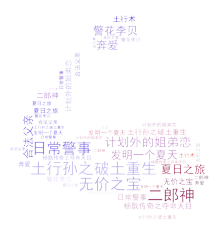

In [ ]:
import wordcloud
from PIL import Image
import matplotlib as mp
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

path_font = '/content/drive/MyDrive/Github/Content/tools/articles/fonts/simhei.ttf'
path_image = "/content/drive/MyDrive/Github/Content/tools/articles/img/muscle-1085672_1280.png"
path_img = '/content/drive/MyDrive/Github/Content/tools/articles/img'
ls = df_focus_narrowed['片名'].to_list() + ls_ptitles 
# highlights
print(ls)

mask = np.array(Image.open(path_image)) # 定义词频背景
wc = wordcloud.WordCloud(
    font_path=path_font,
    mask=mask, # set back ground mask image
    max_words=44,
    max_font_size=144,
    background_color="rgba(255, 255, 255, 0)", mode="RGBA",
    repeat=True,
)
wc.generate(','.join(ls))

image_colors = wordcloud.ImageColorGenerator(mask)
wc.recolor(color_func=image_colors)
plt.imshow(wc) # 显示词云
plt.axis('off') # 关闭坐标轴
plt.show()

wc.to_file(path_img + '/img_title_' + issue_name + '.png')

##[2.5] 生成摘要
2021年4月28日，3月的电影备案公示发布，其中最遥远的是影剧备字〔2021〕第1360号的《幕后英雄》，最近期的是影特备字〔2021〕第006号的《熊猫传奇——黑洞之吻》，慷田AI聚焦、重点关注的项目有中国电影的《发明一个夏天》、光线的《计划外的姐弟恋》、《二郎神》、《土行孙之破土重生》、爱奇艺的《日常警事》以及阿里的《无价之宝》。

In [ ]:
df_focus_narrowed['单位简称'] = df_focus_narrowed['备案单位'].str.extract('('+ pat_public + ")")
df_f = df_focus_narrowed.groupby('单位简称')['片名'].apply(
    lambda x: '、'.join('《' + x + '》')).rename('关注影片').reset_index()
#####
S0 = '{year}年{month}月{day}日，'.format(year=pub_year, month=pub_month, day=pub_day)
S0 +=  '{month}月'.format(month=df_curr.loc[0,'公示批次起始'][1])
if df_curr.loc[0,'公示批次起始'][2] != '整月':
  S0 += '{duration}'.format(duration=df_curr.loc[0,'公示批次起始'][2])
S0 += '的电影备案公示发布，其中'
S0 += '最遥远的是{}的《{}》，'.format(df_curr_sorted.loc[0, '备案立项号'], df_curr_sorted.loc[0, '片名'])
S0 += '最近期的是{}的《{}》，'.format(df_curr_sorted.loc[df_curr.shape[0]-1, 
                                                 '备案立项号'], df_curr_sorted.loc[df_curr.shape[0]-1, '片名'])
S0 += '慷田AI聚焦关注的项目有'
for i, row in df_f.iterrows():
  if i == df_f.shape[0]-1:
    S0 = S0.rstrip('、')
    S0 += '以及{co}的{film}'.format(co=row['单位简称'], film=row['关注影片'])
  else:
    S0 += '{co}的{film}、'.format(co=row['单位简称'], film=row['关注影片'])
S0 += '。'
print(S0)

2021年4月28日，3月的电影备案公示发布，其中最遥远的是影特备字〔2021〕第006号的《熊猫传奇——黑洞之吻》，最近期的是影剧备字〔2021〕第1360号的《幕后英雄》，慷田AI聚焦关注的项目有中国电影的《发明一个夏天》、光线的《土行孙之破土重生》、《二郎神》、《计划外的姐弟恋》、爱奇艺的《日常警事》以及阿里的《无价之宝》。


##[2.6] 指向电影剧官网


In [ ]:
#####
T6 = '\n\n'
T6 += '\t慷田AI结合自主调研及多方大数据比对，通过分析、建模，提炼关键信息。'
T6 += '电影立项备案公示信息来自中国国家电影局 China Film Administration, 官方网址 '
T6 += ' http://www.chinafilm.gov.cn/chinafilm 。'

print(T6)



	慷田AI结合自主调研及多方大数据比对，通过分析、建模，提炼关键信息。电影立项备案公示信息来自中国国家电影局 China Film Administration, 官方网址  http://www.chinafilm.gov.cn/chinafilm 。


#[3] Output Word Document

## 3.1 Install and Load Libraries

In [ ]:
!pip install python-docx
!pip install lxml
from docx import Document
from docx.shared import Inches
#from docx.text.parargaph import Paragraph

## 3.2 Output Docx


In [ ]:
path_doc = '/content/drive/MyDrive/Github/Content/tools/articles/docx'
path_img = '/content/drive/MyDrive/Github/Content/tools/articles/img'

doc = Document()
doc.core_properties.title = 'China Movie Registration Overview ' + issue_name

doc.add_heading(T1, 0)

p = doc.add_paragraph(S0, style='Intense Quote')

doc.add_paragraph(T2)
doc.add_paragraph(T3)

doc.add_picture(path_img + '/img_title_' + issue_name + '.png', width =Inches(3))


table = doc.add_table(rows=1, cols=1, style='Light List Accent 4')
i = 1
for _, row in df_focus_narrowed.iterrows():
  row_cells = table.add_row().cells
  row_cells[0].text = '[' + str(i) + ']' + '《'.format(i) + row['片名'] + '》'

  row_cells = table.add_row().cells
  row_cells[0].text = '编剧: ' + row['编剧']

  row_cells = table.add_row().cells
  row_cells[0].text = '备案单位: ' + row['备案单位']

  row_cells = table.add_row().cells
  row_cells[0].text = row['梗概']

  row_cells = table.add_row().cells
  row_cells[0].text = ''
  i+=1

doc.add_paragraph(T6)

doc.save(path_doc + '/overview_' + issue_name + '.docx' )
